In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import time

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Get a list of patient folders in the data folder.
INPUT_FOLDER = 'example_dcm_sample/'
patients = os.walk('./example_dcm_sample').next()[1]
patients.sort()

In [2]:
# Load the CT and RT documents for a patient.
def load_scan(path):
    slice_rt = [dicom.read_file(path + "/RTst/" + s) for s in os.listdir(path + "/RTst")]
    slice_ct = [dicom.read_file(path + "/CT/" + s) for s in os.listdir(path + "/CT")]
    slice_ct.sort(key = lambda x: int(x.ImagePositionPatient[2]))    
    return slice_ct, slice_rt

In [3]:
# Convert the pixel values to Hounsfield Units.
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [4]:
first_patient_ct, first_patient_rt = load_scan(INPUT_FOLDER + patients[0])

# Make a dictionary mapping the UID values of each slice to the slice number.
uid_location_dict = {}
for i, patient_slice in enumerate(first_patient_ct):
    uid_location_dict[patient_slice[0x0008, 0x0018].value] = i
    
# Construct a list of regions in the whole scan and their points
labeled_regions = {};

# Structure Set ROI Sequence is 3006.0020 in the RTst.
# http://dicom.nema.org/medical/Dicom/2016b/output/chtml/part03/sect_C.8.8.5.html
for i, ss_roi_sequence_i in enumerate(first_patient_rt[0][0x3006, 0x0020].value):
    print ("Found ROI: ", ss_roi_sequence_i[0x3006, 0x0026].value)

# ROI Contour Sequence is 3006.0039 in the Rtst
# http://dicom.nema.org/medical/dicom/2016c/output/chtml/part03/sect_C.8.8.6.html
for i, roi_sequence_i in enumerate(first_patient_rt[0][0x3006, 0x0039].value):
    roi_number = i;
    labeled_regions[roi_number] = { "slices": [] };
    roi_color = roi_sequence_i[0x3006, 0x002A].value;
    contour_sequence = roi_sequence_i[0x3006, 0x0040].value;
    labeled_regions[roi_number]["color"] = roi_color;
    for i, roi_contour_sequence_i in enumerate(contour_sequence):
        # Get the slice number corresponding to roi contour's Referenced SOP Instance UID
        sop_instance_uid = (roi_contour_sequence_i[0x3006,0x0016]).value[0][0x0008,0x1155].value;
        slice_number = uid_location_dict[sop_instance_uid];
        numPoints = roi_contour_sequence_i[0x3006, 0x0046].value;
        contour_type = roi_contour_sequence_i[0x3006, 0x0042].value;
        if contour_type != "CLOSED_PLANAR":
            print("Unsupported contour type found of type ", contour_type);
            exit();
        points = np.array(roi_contour_sequence_i[0x3006, 0x0050].value);
        points.shape = (numPoints, 3);
        zipped = zip(*points);
        zipped[0] = np.subtract(zipped[0], first_patient_ct[slice_number].ImagePositionPatient[0])
        zipped[0] = np.divide(zipped[0], first_patient_ct[slice_number].PixelSpacing[0])
        zipped[1] = np.subtract(zipped[1], first_patient_ct[slice_number].ImagePositionPatient[1])
        zipped[1] = np.divide(zipped[1], first_patient_ct[slice_number].PixelSpacing[1])
        zipped[2] = np.subtract(zipped[2], first_patient_ct[0].ImagePositionPatient[2])
        zipped[2] = np.divide(zipped[2], first_patient_ct[slice_number].SliceThickness)
        labeled_regions[roi_number]["slices"].append({
            "sliceNum": slice_number,
            "z": zipped[2][0],
            "data": zipped
        });
        
labeled_regions[2]["slices"] = sorted(labeled_regions[2]["slices"], key=lambda item: item["z"])
        
first_patient_pixels = get_pixels_hu(first_patient_ct)

('Found ROI: ', 'body')
('Found ROI: ', 'Esophagus')
('Found ROI: ', 'lung')
('Found ROI: ', 'radiomics_gtv')


In [5]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel to mm ratio
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)
    # Get shape in mm
    new_real_shape = image.shape * spacing
    # Round to nearest integer
    new_shape = np.round(new_real_shape)
    # Get pixel to mm ratio after rounding
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    # Zoom the 3d scan as necessary    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    return image, new_spacing

In [6]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient_ct, [1,1,1])

In [9]:
def plot_3d(image, labeled_regions, threshold=-300):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    ground_truth = np.zeros(p.shape);

    for i, region_slice in enumerate(labeled_regions[2]["slices"]):
        region_points = [zip(region_slice["data"][0], region_slice["data"][1], region_slice["data"][2])]
        for j in range(len(region_slice["data"][0])):
            ground_truth[int(region_slice["data"][0][j]),int(region_slice["data"][1][j]),int(region_slice["data"][2][j])] = 1.0;

    verts, faces = measure.marching_cubes(ground_truth, 0)
    body_mesh = Poly3DCollection(verts[faces], alpha=0.1)
    body_mesh_color = [0, 0, 1]
    body_mesh.set_facecolor(body_mesh_color)
    ax.add_collection3d(body_mesh)
    
#     verts, faces = measure.marching_cubes(p, threshold)
#     body_mesh = Poly3DCollection(verts[faces], alpha=0.1)
#     body_mesh_color = [1, 0, 0]
#     body_mesh.set_facecolor(body_mesh_color)
#     ax.add_collection3d(body_mesh)
    
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    
    #ax.view_init(0,90);

    plt.show()

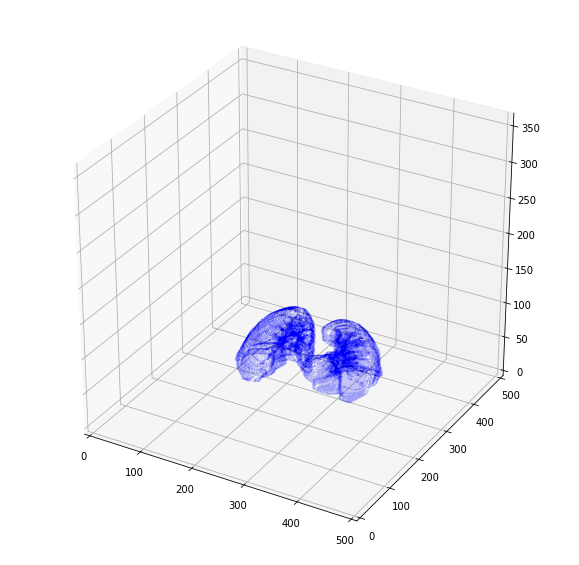

In [10]:
plot_3d(pix_resampled, labeled_regions, 1)